### This file decribes how to get scrape a working csv-file from wikinews.org

# IT NEED A LOT OF STUFF NOT IMPLEMENTED COMPLITELY

Table taken from: https://github.com/several27/FakeNewsCorpus - go there for better table formating

| Type | Tag | Count (so far) | Description|
| ------------- |-------------|:-------------:|:-------------:|
| **Fake News** | fake | 928,083 | Sources that entirely fabricate information, disseminate deceptive content, or grossly distort actual news reports |
| **Satire** | satire | 146,080 | Sources that use humor, irony, exaggeration, ridicule, and false information to comment on current events. |
| **Extreme Bias** | bias | 1,300,444 | Sources that come from a particular point of view and may rely on propaganda, decontextualized information, and opinions distorted as facts. |
| **Conspiracy Theory** | conspiracy | 905,981 | Sources that are well-known promoters of kooky conspiracy theories. |
| **State News** | state | 0 | Sources in repressive states operating under government sanction. |
| **Junk Science** | junksci | 144,939 | Sources that promote pseudoscience, metaphysics, naturalistic fallacies, and other scientifically dubious claims. |
| **Hate News** | hate | 117,374 | Sources that actively promote racism, misogyny, homophobia, and other forms of discrimination. |
| **Clickbait** | clickbait | 292,201 | Sources that provide generally credible content, but use exaggerated, misleading, or questionable headlines, social media descriptions, and/or images. |
| **Proceed With Caution** | unreliable | 319,830 | Sources that may be reliable but whose contents require further verification. |
| **Political** | political | 2,435,471 | Sources that provide generally verifiable information in support of certain points of view or political orientations. |
| **Credible** | reliable | 1,920,139 | Sources that circulate news and information in a manner consistent with traditional and ethical practices in journalism (Remember: even credible sources sometimes rely on clickbait-style headlines or occasionally make mistakes. No news organization is perfect, which is why a healthy news diet consists of multiple sources of information). |

In [1]:
# Follow the link below:
# https://www.kaggle.com/sudalairajkumar/getting-started-with-text-preprocessing
# https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/



import psycopg2
import pandas as pd
import numpy as np
import seaborn as sns
import re
import string

### Import and get basic information about the data

First we import the data and get an idea about how it it structured and so on such that we can better understand what has to be done.

- Below we import and create a type_id colum (might remove later)


In [58]:
filepath = '../Data_git_ignore/liar_test.tsv'

# Create df for the entire file
entire_df = pd.read_csv(filepath,
                        index_col = [0],
                        sep='\t',
                        encoding='utf-8',
                        names=["type", "content", "subject(s)", "speaker", "speaker's job title.", "state info.", "party affiliation.", "a", "b", "c", "d", "e", "f"]
                        )
entire_df = entire_df[['type', 'content']]

# Make index to Int
entire_df.reset_index(inplace = True, drop = True)

## CHange types to be only fake or reliable
fake     = 3

reliable = 7

fake     = false, pants-fire
reliable = true, mostly-true

Exclude  = barely-true, half-true

In [ ]:
fake_types     = ['false', 'pants-fire']
reliable_types = ['true', 'mostly-true']

fake_types[]entire_df

In [64]:
t = 'false'
entire_df.loc[entire_df['type'] == t]

,type,content,type_id
1,false,Wisconsin is on pace to double the number of l...,1
2,false,Says John McCain has done nothing to help the ...,1
13,false,Says 57 percent of federal spending goes to th...,1
19,false,Ronald Reagan faced an even worse recession th...,1
24,false,Says Charlie Crist is embroiled in a fraud cas...,1
...,...,...,...
1222,false,At least a quarter of those apprehended at the...,1
1228,false,"When it comes to jobless workers, Mitt Romney ...",1
1255,false,There is no system to vet refugees from the Mi...,1
1260,false,I think its seven or eight of the California s...,1


In [60]:
### Below are overall integrity cleaning ###

# # Drop non-numeric id's
# entire_df['id'] = pd.to_numeric(entire_df['id'], errors = 'coerce', downcast = 'integer')
# entire_df.dropna(subset=['id'], inplace = True)

# # Set id to int
# entire_df['id'] = entire_df['id'].astype(int)

# content has to be unique
entire_df.drop_duplicates(['content'], inplace = True)

# Drop rows wiht type-nan´
entire_df = entire_df[entire_df['type'].notna()]

# Create type_id column
entire_df['type_id'] = entire_df.groupby(['type']).ngroup()

entire_df

,type,content,type_id
0,true,Building a wall on the U.S.-Mexico border will...,5
1,false,Wisconsin is on pace to double the number of l...,1
2,false,Says John McCain has done nothing to help the ...,1
3,half-true,Suzanne Bonamici supports a plan that will cut...,2
4,pants-fire,When asked by a reporter whether hes at the ce...,4
...,...,...,...
1262,half-true,Says his budget provides the highest state fun...,2
1263,barely-true,Ive been here almost every day.,0
1264,barely-true,"In the early 1980s, Sen. Edward Kennedy secret...",0
1265,barely-true,Says an EPA permit languished under Strickland...,0


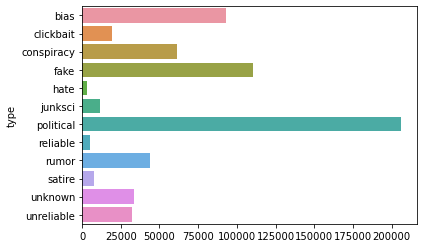

In [67]:
### Show info about "entire"-dataset ###

# Show rows for each type
types = entire_df.groupby('type').content.count()
sns.barplot(types.values, types.index)

In [3]:
### SELECT SIZE OF -> sub-dataset ###

# This can generate a dataset with random purmutation and a max size for each type(can be smaller if desired max is not possible)

# max size for type
max_size = 5000
# Labels to include - ['fake', 'satire', 'bias', 'conspiracy', 'state', 'junksci', 'hate', 'clickbait', 'unreliable', 'political', 'reliable'] - all labels
use_types = ['fake', 'satire', 'bias', 'conspiracy', 'junksci', 'hate', 'rumor', 'clickbait', 'unreliable', 'political', 'reliable', 'unknown']
# Random seed
rnd = 1

# initialize dataframes
df = pd.DataFrame(columns = entire_df.columns)

# add type to test splits
for t in use_types:

    # type size
    type_size = entire_df['type'].loc[entire_df['type'] == t].value_counts().min()

    # set size of type slice
    if type_size < max_size:
        tmp = entire_df.loc[entire_df['type'] == t].sample(n = type_size, random_state=rnd)
    else:
        tmp = entire_df.loc[entire_df['type'] == t].sample(n = max_size, random_state=rnd)
    
    # add tmp to dataframes
    df = pd.concat([df, tmp])
    
    # print split shape
    print("=>", t, tmp.shape)

print("\n[Final sub-dataset]\nwhole ==>", df.shape)

=> fake (20, 17)
=> satire (20, 17)
=> bias (20, 17)
=> conspiracy (20, 17)
=> junksci (20, 17)
=> hate (20, 17)
=> rumor (20, 17)
=> clickbait (20, 17)
=> unreliable (20, 17)
=> political (20, 17)
=> reliable (20, 17)
=> unknown (20, 17)

[Final sub-dataset]
whole ==> (240, 17)


,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary,source,type_id
count,240,240,240,240,240,240,240,240,240,138,0,240,109,94,0,0,240
unique,240,60,12,240,240,2,1,1,230,114,0,32,106,74,0,0,12
missing,0,0,0,0,0,0,0,0,0,102,240,0,131,146,240,240,0


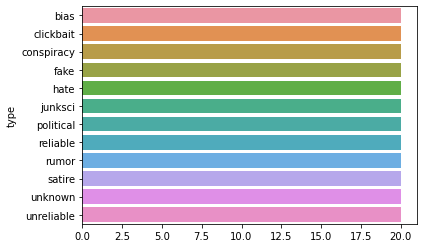

In [4]:
### Show info about sub-dataset ###

# Show rows for each type
types = df.groupby('type').content.count()
sns.barplot(types.values, types.index)

# Show "descibe" data
describe_df = df.describe(include=[np.object]).head(2)
nan_df = df.isna().sum()
describe_df.loc['missing'] = nan_df
describe_df

In [5]:
### REMOVE AND REPLACE -> NaN/Empty elmements ###

# Remove rows where columns are NaN
df.dropna(subset=['title'])

# Replace NaN-elements with 'NULL'
df = df.fillna('NULL')

# Replace "['']" - these are NaN 
regex = r"\[''\]"
df['meta_keywords'] = df['meta_keywords'].replace(to_replace=regex, value='NULL', regex=True)

# Replace '_' or '' (empty str) from "string-like" columns - these are NaN
regex = r"^$|^ +"
columns = ['domain', 'type', 'url', 'content', 'title', 'authors', 'keywords', 'meta_description', 'tags', 'summary', 'source']
df[columns] = df[columns].replace(to_replace=regex, value='NULL', regex=True)

### Dataset Preparation

Here we start the cleaning process. There are a lot of steps and the code can be a little complicated. Some steps have to be before others as they overrule the previous 

- how to implement is still up for debate as it can be smart to use small cells for each step or get all in one big cleaning step but display when they are done
- **READ** all excersice 1-7 on KU

### Common data cleaning steps
- make text all lower case
- remove puntuiation
- remove numerical values
- remove common non-sensial text(/n)
- tokanize text

### # steps that need to be included
- -NUM -DATE -EMAIL -URL
- replace nan with 'NULL'

### Text blob cleaning
The first cleaning-step is wokring on text blobs ie. all text at the same time

In [6]:
# # working with content as a series
series_content = df['content']

### Order matters - (not final order of pipeline)
### Overall preprocessing

# lower_cast - NEEDED? - DONE by many libs
%time print("\n (lower_cast)"); series_content = series_content.str.lower()

### replace [name] with tokens in text ###

# Email_replace
regexEmail = r"[a-zA-Z_-]+@[a-zA-Z_-]+(?:\.[a-zA-Z]{2,4}){1,3}"
%time print("\n (Email_replace)"); series_content = series_content.replace(to_replace=regexEmail, value=' EMAIL ', regex=True)

# replace URLs  with token
regexURL= r"(?:https?:\/\/)?(?:www\.)?([^@\s]+\.[a-zA-Z]{2,4})[^\s]*"
%time print("\n (URL_replace)"); series_content = series_content.replace(to_replace=regexURL, value=' URL ', regex=True)

# HTML_replace
regexHTML = r"<\s*a[^>]*>(.*?)<\s*/\s*a>"
%time print("\n (HTML_replace)"); series_content = series_content.replace(to_replace=regexHTML, value=' HTML ', regex=True)

# Date_replace - NOT DONE
# - name         (jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)
# - day in month ([12]\d|3[01]|0?[1-9]) - Day 0-31
# - year         ([12][0-9]{3})         - Years from 1000 to 2999
regexDate = r"(((19[7-9]\d|20\d{2})|(?:jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|(nov|dec)(?:ember)?)|(([12][0-9])|(3[01])|(0?[1-9])))[\/. \-,\n]){2,3}"
%time print("\n (Date_replace)"); series_content = series_content.replace(to_replace=regexDate, value=' DATE ', regex=True)

# Number_replace
regexNum = r"[0-9][0-9,\.]+" # nums with [0-9] and [,.]
%time print("\n (Number_replace)"); series_content = series_content.replace(to_replace=regexNum, value=' NUM ', regex=True)

### string removal functions ###

# Punctuation_remove
regexPunkt = r"[!“”\"#$%&()*+,\-–.…\/:;<=>?@[\\\]^_`{|}~'\’\'»]" # also removes: " ' " which means ie. it's -> its - remove \' from regwex if not needed
%time print("\n (Punctuation_remove)"); series_content = series_content.replace(to_replace=regexPunkt, value='', regex=True)

# whitespace_remove
regexWhiteSpace = r"\s+|\\n+"
%time print("\n (whitespace_remove)"); series_content = series_content.replace(to_replace=regexWhiteSpace, value=' ', regex=True)

# # Non_ASCII_remove - Maybe a step too much
# %time print("\n (Non_ASCII_remove)"); series_content = series_content.str.encode('ascii', 'ignore').str.decode('ascii')

# After all steps
print("\n (Done cleaning)")


 (lower_cast)
Wall time: 15 ms

 (Email_replace)
Wall time: 27 ms

 (URL_replace)
Wall time: 114 ms

 (HTML_replace)
Wall time: 1 ms

 (Date_replace)
Wall time: 317 ms

 (Number_replace)
Wall time: 8 ms

 (Punctuation_remove)
Wall time: 14 ms

 (whitespace_remove)
Wall time: 72.1 ms

 (Done cleaning)


In [7]:
series_content.iloc[0]

'we are witnessing a great turning inward in the global war on terror by fascist us authorities and their corrupt collaborators in the corporate world and in other governments the sword of the totalitarian state is no longer directed against alqaeda which is now unofficially a us ally in the war against syria but against internal critics who are being labeled domestic extremists and homegrown terrorists internal critics were dismissed by the establishment as crazy conspiracy theorists and paranoid loons but the truth about DATE has spread so widely in society that these terms no longer perform the function of thought control the defeat of the propaganda system has put the tyrants in washington in a tough spot because they want to retain control over the american people but they can no longer do so with word ricks and media brainwashing as a result the failed terrorist state in washington is making america a closed society with a vast secret police domestic kill list and military facili

In [8]:
### DEBUG content regex ###

# r = 4
# m = 4
# mutl_sample = df['content'].sample(5, random_state=r)
# before = mutl_sample
# print(mutl_sample)
# print(repr(mutl_sample.iloc[m]))

# ### DEBUG SETUP - COMPARE CLEAN VS NON_CLEAN ###
# series_content = mutl_sample
# ### DEBUG SETUP - COMPARE CLEAN VS NON_CLEAN ###

# ### DEBUG PRINT - COMPARE CLEAN VS NON_CLEAN ###
# print("[before]\n", repr(before.iloc[m]), "\n\n[After]\n", repr(series_content.iloc[m]) )
# ### DEBUG PRINT - COMPARE CLEAN VS NON_CLEAN ###


# for elm in range(len(mutl_sample)):
#     print("\n\n[before]\n", repr(before.iloc[m]), "\n[After]\n", repr(series_content.iloc[m]) )

In [10]:
series_content.str.split()

1496    [we, are, witnessing, a, great, turning, inwar...
8192    [more, than, a, parade, and, my, new, manifest...
5154    [dallas, gun, buyback, program, countered, wit...
2272    [by, paul, j, balles, many, industries, that, ...
2198    [enterprise, vsat, market, global, research, a...
                              ...                        
3304    [advertisement, as, you, see, i, could, go, on...
9766    [i, wrote, this, last, night, after, i, learne...
8698    [now, this, is, how, you, earn, civil, rights,...
1935    [advertisement, put, option, on, america, part...
7002    [in, my, previous, piece, progressive, tea, pa...
Name: content, Length: 240, dtype: object

In [32]:
# # Lexemize content

# # imports used
# import swifter
# import spacy
# nlp = spacy.load('en_core_web_sm')
# # nlp = spacy.load('xx_ent_wiki_sm')

# # # Lemma function
# # def lemmatizer(text):        
# #     sent = []
# #     doc = nlp(text)
# #     for word in doc:
# #         sent.append(word.lemma_)
# #     # return string_list
# #     return "{" + str(sent)[1:-1] + "}"

# # Lemma function
# def lemmatizer(text):        
#     sent = []
#     doc = nlp(text)
#     for word in doc:
#         sent.append(word.lemma_)
#     # return string_list
#     return sent

# # Assingn Series for return
# content_tokenize_series = series_content.swifter.apply(lambda x: lemmatizer(x), axis=1)

# Faster but not as precise
content_tokenize_series = series_content.str.split()

regexStrList = r"\["
content_tokenize_series = content_tokenize_series.replace(to_replace=regexStrList, value='{', regex=True)
regexStrList = r"\]"
content_tokenize_series = content_tokenize_series.replace(to_replace=regexStrList, value='}', regex=True)

In [33]:
content_tokenize_series

1496    [we, are, witnessing, a, great, turning, inwar...
8192    [more, than, a, parade, and, my, new, manifest...
5154    [dallas, gun, buyback, program, countered, wit...
2272    [by, paul, j, balles, many, industries, that, ...
2198    [enterprise, vsat, market, global, research, a...
                              ...                        
3304    [advertisement, as, you, see, i, could, go, on...
9766    [i, wrote, this, last, night, after, i, learne...
8698    [now, this, is, how, you, earn, civil, rights,...
1935    [advertisement, put, option, on, america, part...
7002    [in, my, previous, piece, progressive, tea, pa...
Name: content, Length: 240, dtype: object

## Cleaning for other colums

In [29]:
# cleaning for other columns

# to-do add case for words line Niel's thois is pt transalted into Niels

# meta keywords has to be array_like_list - {elm1, elm2...}
regexStrList = r"\["
df['meta_keywords'] = df['meta_keywords'].replace(to_replace=regexStrList, value='{', regex=True)
regexStrList = r"\]"
df['meta_keywords'] = df['meta_keywords'].replace(to_replace=regexStrList, value='}', regex=True)

## Insert into dataframe and write to csv

In [30]:
# Insert series with changes into dataframe write csv-file

df['content_tokenize'] = content_tokenize_series


df['content'] = series_content

# write csv
df.to_csv('../Data_git_ignore/clean_corpus.csv', index=True, header=True)

# clean wiki

In [12]:
# importing and creating df (has to have type_id)

# usage: specify file location, sample size and seed(used by random) 
filepath = '../Data_sample/wiki_news_raw_backup.csv' # 250 rows of FakeNewsCorpus
s = 50                                             # desired sample size
seed = 1                                           # seed used by Pseudorandom number generator

df = pd.read_csv(filepath, index_col = [0])
df["content"] = df["content"].astype(str)

df.shape

(3680, 7)

In [13]:
# # working with content as a series
series_content = df['content']

### Order matters - (not final order of pipeline)
### Overall preprocessing

# lower_cast - NEEDED? - DONE by many libs
%time print("\n (lower_cast)"); series_content = series_content.str.lower()

### replace [name] with tokens in text ###

# Email_replace
regexEmail = r"[a-zA-Z_-]+@[a-zA-Z_-]+(?:\.[a-zA-Z]{2,4}){1,3}"
%time print("\n (Email_replace)"); series_content = series_content.replace(to_replace=regexEmail, value=' EMAIL ', regex=True)

# replace URLs  with token
regexURL= r"(?:https?:\/\/)?(?:www\.)?([^@\s]+\.[a-zA-Z]{2,4})[^\s]*"
%time print("\n (URL_replace)"); series_content = series_content.replace(to_replace=regexURL, value=' URL ', regex=True)

# HTML_replace
regexHTML = r"<\s*a[^>]*>(.*?)<\s*/\s*a>"
%time print("\n (HTML_replace)"); series_content = series_content.replace(to_replace=regexHTML, value=' HTML ', regex=True)

# Date_replace - NOT DONE
# - name         (jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)
# - day in month ([12]\d|3[01]|0?[1-9]) - Day 0-31
# - year         ([12][0-9]{3})         - Years from 1000 to 2999
regexDate = r"(((19[7-9]\d|20\d{2})|(?:jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|(nov|dec)(?:ember)?)|(([12][0-9])|(3[01])|(0?[1-9])))[\/. \-,\n]){2,3}"
%time print("\n (Date_replace)"); series_content = series_content.replace(to_replace=regexDate, value=' DATE ', regex=True)

# Number_replace
regexNum = r"[0-9][0-9,\.]+" # nums with [0-9] and [,.]
%time print("\n (Number_replace)"); series_content = series_content.replace(to_replace=regexNum, value=' NUM ', regex=True)

### string removal functions ###

# Punctuation_remove
regexPunkt = r"[!“”\"#$%&()*+,\-–.…\/:;<=>?@[\\\]^_`{|}~'\’\']" # also removes: " ' " which means ie. it's -> its - remove \' from regwex if not needed
%time print("\n (Punctuation_remove)"); series_content = series_content.replace(to_replace=regexPunkt, value='', regex=True)

# whitespace_remove
regexWhiteSpace = r"\s+|\\n+"
%time print("\n (whitespace_remove)"); series_content = series_content.replace(to_replace=regexWhiteSpace, value=' ', regex=True)

# start_whitespace_remove
regexStartWhite = r"^ "
%time print("\n (whitespace_remove)"); series_content = series_content.replace(to_replace=regexStartWhite, value='', regex=True)

# # Non_ASCII_remove - Maybe a step too much
# %time print("\n (Non_ASCII_remove)"); series_content = series_content.str.encode('ascii', 'ignore').str.decode('ascii')

# After all steps
print("\n (Done cleaning)")


 (lower_cast)
Wall time: 1.23 s

 (Email_replace)
Wall time: 200 ms

 (URL_replace)
Wall time: 1.14 s

 (HTML_replace)
Wall time: 11 ms

 (Date_replace)
Wall time: 2.88 s

 (Number_replace)
Wall time: 169 ms

 (Punctuation_remove)
Wall time: 140 ms

 (whitespace_remove)
Wall time: 557 ms

 (whitespace_remove)
Wall time: 90.4 ms

 (Done cleaning)


## Cleaning for other colums

In [14]:
# Lexemize content

# # imports used
# import swifter
# import spacy
# nlp = spacy.load('en_core_web_lg')
# # nlp = spacy.load('xx_ent_wiki_sm')

# # Lemma function
# def lemmatizer(text):        
#     sent = []
#     doc = nlp(text)
#     for word in doc:
#         sent.append(word.lemma_)
#     # return string_list
#     return "{" + str(sent)[1:-1] + "}"

# # Assingn Series for return
# content_tokenize_series = series_content.swifter.apply(lambda x: lemmatizer(x), axis=1)

# # Faster but not as precise
# content_tokenize_series = series_content.str.split()
# regexStrList = r"\["
# content_tokenize_series = content_tokenize_series.replace(to_replace=regexStrList, value='{', regex=True)
# regexStrList = r"\]"
# content_tokenize_series = content_tokenize_series.replace(to_replace=regexStrList, value='}', regex=True)

## Cleaning for other columns

In [15]:
# to-do add case for words line Niel's thois is pt transalted into Niels

# Data formating - use fist date
regexStrList = r".*?(.+? [0-9]{1,2}, [0-9]{4}).*"
df['publish_date'] = df['publish_date'].replace(to_replace=regexStrList, value=r'\1', regex=True)

In [16]:
# df['content'] = df['content'].str.split(" ")
df['content']          = series_content
df['content_tokanize'] = content_tokenize_series
df.head()

,categories,content,publish_date,scraped_at,source_urls,sources_domain_urls,title,content_tokanize
article_url,,,,,,,,
https://en.wikinews.org/wiki/Ma_Ying-jeou_becomes_President_of_Republic_of_China,"May 20, 2008,Translated news,Published,Archive...",today ma yingjeou was sworn in as the presiden...,"May 20, 2008",2020-04-22,http://www.radioaustralia.net.au/news/stories/...,"https://en.wikipedia.org/wiki/Radio_Australia,...",Ma Ying-jeou becomes President of Republic of ...,"[today, ma, yingjeou, was, sworn, in, as, the,..."
https://en.wikinews.org/wiki/Violence_cuts_short_visit_of_Dominican_Republic_president,"December 15, 2005,Published,Archived,Haiti,Pol...",protests against the president of the dominica...,"December 15, 2005",2020-04-22,http://seattlepi.nwsource.com/national/1102AP_...,"/wiki/Associated_Press,https://en.wikipedia.or...",Violence cuts short visit of Dominican Republi...,"[protests, against, the, president, of, the, d..."
"https://en.wikinews.org/wiki/Wikinews_Shorts:_February_20,_2014","February 20, 2014,Wikinews Shorts,Published,Ar...",a compilation of brief news reports for ukrain...,"February 20, 2014",2020-04-22,http://www.cnn.com/2014/02/19/world/europe/ukr...,"/wiki/CNN,/wiki/The_Guardian,/wiki/NBC_News,/w...","Wikinews Shorts: February 20, 2014","[a, compilation, of, brief, news, reports, for..."
"https://en.wikinews.org/wiki/Violence_continues_in_Baghdad,_suspected_al-Quaeda_leader_arrested","September 5, 2006,Published,AutoArchived,Polit...",iraq witnessed more violence with more than NU...,"September 5, 2006",2020-04-22,http://news.bbc.co.uk/go/rss/-/2/hi/middle_eas...,"/wiki/BBC_News_Online,/wiki/Fox_News,/wiki/BBC...","Violence continues in Baghdad, suspected al-Qu...","[iraq, witnessed, more, violence, with, more, ..."
https://en.wikinews.org/wiki/Wyclef_Jean_considering_standing_for_president_of_Haiti,"July 28, 2010,Haiti,United States,Politics and...",following months of rumours musician today con...,"July 28, 2010",2020-04-22,http://www.guardian.co.uk/world/2010/jul/27/wy...,"/wiki/The_Guardian,https://en.wikipedia.org/wi...",Wyclef Jean considering standing for president...,"[following, months, of, rumours, musician, tod..."


In [17]:
df['content'].iloc[0]

'today ma yingjeou was sworn in as the president of the republic of china also known as taiwan and delivered his inauguration speech entitled taiwans renaissance in his speech he discussed four issues he called for people to establish mutual trust and seek common ground while ignoring differences setting aside disputes and creating a winwin situation which was also promoted by jintao hu ma also stressed three of his principles no reunification no independence no war he also said he hopes the governmental executives of china can positively appreciate one china but agree to differ on its definition under the NUM consensus in the speech ma also said that he hopes that new cabinet members of executive yuan will establish the example of clean government and ensure the rights and interests of the disadvantaged minorities in the future '

## insert and write csv

In [18]:
# inset all changes and write csv file

#df['content'] = series_content

# write csv
df.to_csv('../Data_git_ignore/wiki_news_clean.csv', index=True, header=True)

In [19]:
df['content'].iloc[0]

'today ma yingjeou was sworn in as the president of the republic of china also known as taiwan and delivered his inauguration speech entitled taiwans renaissance in his speech he discussed four issues he called for people to establish mutual trust and seek common ground while ignoring differences setting aside disputes and creating a winwin situation which was also promoted by jintao hu ma also stressed three of his principles no reunification no independence no war he also said he hopes the governmental executives of china can positively appreciate one china but agree to differ on its definition under the NUM consensus in the speech ma also said that he hopes that new cabinet members of executive yuan will establish the example of clean government and ensure the rights and interests of the disadvantaged minorities in the future '